In [1]:
import sys
sys.path.append('/home/kevinteng/Desktop/BrainTumourSegmentation')
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
import os 
import utils
from utils_vis import plot_comparison, plot_labels_color 
from utils import dice_coef, ss_metric, compute_metric
%matplotlib inline

/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-package

- Blue => Label 1 (Necrotic and Non-enhancing Tumor Core)
- Yellow => Label 2 (Peritumoral Edema)
- Brown => Label 3/4 (GD-Enhancing Tumor)
---
* Core => Label 1 & 3
* Enhancing => Label 3
* Complete => Label 1,2, 3

---

# Hyperparameter

In [2]:
SHUFFLE_BUFFER = 4000
BATCH_SIZE = 8
lr = 0.00001
opt = tf.keras.optimizers.Adam(lr)
ver = 'ResAttUnet_01' #save version 
dropout=0.2 #dropout rate
hn = 'he_normal' #kernel initializer 
tfrecords_read_dir = '/home/kevinteng/Desktop/ssd02/BraTS20_tfrecords03/HGG/'

---

# Helper Functions

In [3]:
xent = tf.keras.losses.CategoricalCrossentropy()

def generalized_dice(y_true, y_pred, smooth = 1e-5):
    """
    Generalized Dice Score
    https://arxiv.org/pdf/1707.03237
    https://github.com/Mehrdad-Noori/Brain-Tumor-Segmentation/blob/master/loss.py
    """
    
    y_true    = tf.reshape(y_true,shape=(-1,4))
    y_pred    = tf.reshape(y_pred,shape=(-1,4))
    sum_p     = tf.reduce_sum(y_pred, -2)
    sum_r     = tf.reduce_sum(y_true, -2)
    sum_pr    = tf.reduce_sum(y_true * y_pred, -2)
    weights   = tf.math.pow(tf.math.square(sum_r) + smooth, -1)
    generalized_dice = (2 * tf.reduce_sum(weights * sum_pr)) / (tf.reduce_sum(weights * (sum_r + sum_p)))
    return generalized_dice

def generalized_dice_loss(y_true, y_pred):   
    return 1-generalized_dice(y_true, y_pred)
    
def custom_loss(y_true, y_pred):
    
    """
    The final loss function consists of the summation of two losses "GDL" and "CE"
    with a regularization term.
    """
    
    return generalized_dice_loss(y_true, y_pred) + 1.25 * xent(y_true, y_pred)

----

# Model

In [4]:
from utils_model import conv_block, coordconv_block, up, pool, attention_block
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Activation, Add, Multiply
from tensorflow.keras.layers import BatchNormalization,PReLU

def up_res(x_in, filters, merge, kernel_initializer='glorot_uniform', up_scale=(2, 2)):
    u = UpSampling2D(up_scale)(x_in)
    #convolution of 2x2 but linear activation
    conv = Conv2D(filters, kernel_size=(2,2), 
                   padding='same', kernel_initializer=kernel_initializer)(u) 
    concat = tf.concat([merge, conv], axis=-1)
    return concat

def dual_conv(x, filters, batch_norm=True, kernel_initializer='glorot_uniform'):
    if batch_norm:
        x = BatchNormalization()(x)
    x = PReLU(shared_axes = [1, 2])(x)
    x = Conv2D(filters, 3, padding='same', kernel_initializer=kernel_initializer)(x)
    if batch_norm:
        x = BatchNormalization()(x)
    x = PReLU(shared_axes = [1, 2])(x)
    x = Conv2D(filters, 3, padding='same', kernel_initializer=kernel_initializer)(x)
    return x

def residual_block(x_in, filters, batch_norm=True, encoder_path = True, 
                kernel_initializer='glorot_uniform'):
    #only for downsampling strides = 2
    if encoder_path:
        pre_skip = Conv2D(filters, kernel_size=(2,2), strides=(2, 2), 
                   padding='same', kernel_initializer=kernel_initializer)(x_in)
    #entry block and upsampling block does not need stride 2
    if not encoder_path: 
        pre_skip = Conv2D(filters, kernel_size=(2,2), 
           padding='same', kernel_initializer=kernel_initializer)(x_in)
    #two layers of CNN
    x = dual_conv(pre_skip, filters, batch_norm, kernel_initializer)
    #addition for skip connection in res unit
    if encoder_path:
        x = Add()([x,pre_skip])
    else:
        x = Conv2D(filters, 1, use_bias=False)(x)
        x = Add()([x,pre_skip])
    return x

def ResAttUnet_model(input_layer, attention_mode='grid'):
    #entry block
    #input shape [?,240,240,1], output shape  [?,240,240,1]
    entry = Conv2D(64, kernel_size=(2,2), padding='same', 
                    kernel_initializer=hn)(input_layer)
    res01 = dual_conv(entry, 64, kernel_initializer=hn)
    res01 = Add()([res01, entry])
    #downsampling path
#     res01 = residual_block(input_layer, filters=64, kernel_initializer=hn)
    #input shape [?,240,240,1], output shape  [?,120,120,1]
    res02 = residual_block(res01, filters=128, kernel_initializer=hn)    
    #input shape [?,120,120,1], output shape  [?,60,60,1]
    res03 = residual_block(res02, filters=256, kernel_initializer=hn)
    #bottle neck layer
    #input shape [?,60,60,1], output shape  [?,30,30,1]
    res04 = residual_block(res03, filters=512, kernel_initializer=hn)
    
    #upsampling path
    #input shape [?,30,30,1], output shape  [?,60,60,1]
    att01 = attention_block(res03, res04, 256)
    up01 = up_res(res04,filters=256, merge=att01, kernel_initializer=hn)
    res05 = residual_block(up01, filters=256, encoder_path = False, kernel_initializer=hn)
    #input shape [?,60,60,1], output shape  [?,120,120,1]
    if attention_mode=='grid':
        att02 = attention_block(res02, res05, 128)
    else:
        att02 = attention_block(res02, res03, 128)
    up02 = up_res(res05,filters=128, merge=att02, kernel_initializer=hn)
    res06 = residual_block(up02, filters=128, encoder_path = False, kernel_initializer=hn)
    #input shape [?,120,120,1], output shape  [?,240,240,1]
    if attention_mode=='grid':
        att03 = attention_block(res01, res06, 64)
    else:
        att03 = attention_block(res01, res02, 64)
    up03 = up_res(res06,filters=64, merge=att03, kernel_initializer=hn)
    res07 = residual_block(up03, filters=64, encoder_path = False, kernel_initializer=hn)
    
    output_layer = BatchNormalization()(res07)
    output_layer = PReLU(shared_axes = [1, 2])(output_layer)
    output_layer = Conv2D(4, (1,1), activation = 'softmax')(output_layer)
    
    return output_layer

In [5]:
input_layer = Input(shape=(240,240,4))
model = Model(input_layer, ResAttUnet_model(input_layer))

In [6]:
#to do..Sensitivity
xent = tf.keras.losses.CategoricalCrossentropy()
@tf.function
def train_fn(image, label):
    with tf.GradientTape() as tape:
        model_output = model(image)
        loss = generalized_dice_loss(label, model_output)
    gradients = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    
    return model_output, loss, gradients


Epochs  1



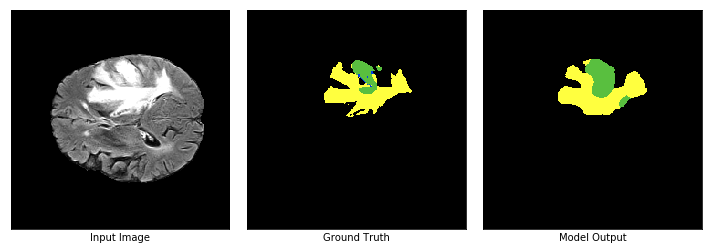

Steps: 2000, Loss:0.46506279706954956
Accurary: 0.9810937643051147
Dice coefficient: [0.70190024, 0.67995167, 0.87431526]
Sensitivity: [0.9641109304386472, 0.9623931630360143, 0.968318166604927]
Specificity: [0.9915770263408186, 0.9910900640198036, 0.9866015045875933]
Gradient min:-0.024307318031787872, max:0.018961623311042786



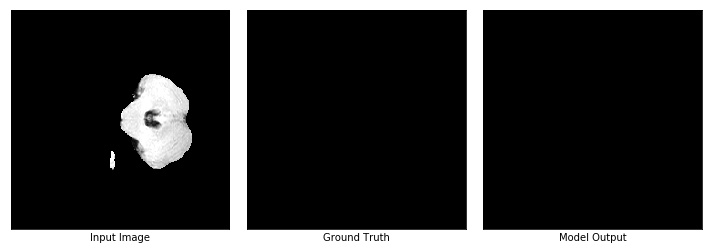

Steps: 4000, Loss:1.0
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-1.4777837287205386e-10, max:2.3084505140769096e-10

Epochs  2



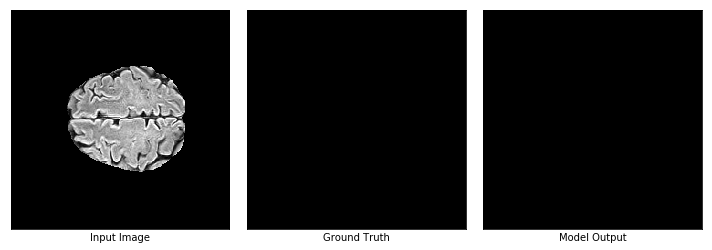

Steps: 2000, Loss:0.9999998807907104
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-1.0131765293408534e-06, max:1.22012522751902e-06



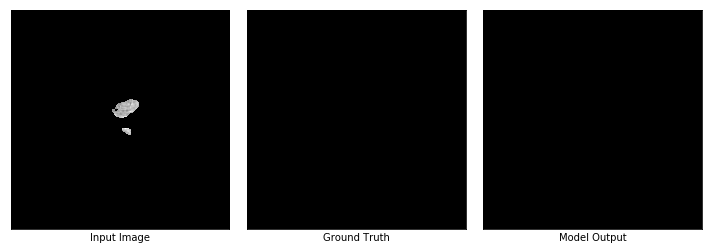

Steps: 4000, Loss:0.9887337684631348
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.06195266172289848, max:0.07307213544845581

Epochs  3



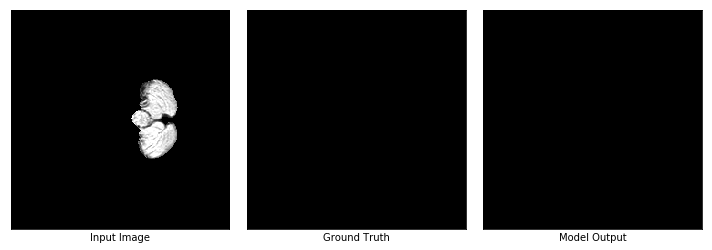

Steps: 2000, Loss:0.3061811923980713
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.05556715279817581, max:0.048045601695775986



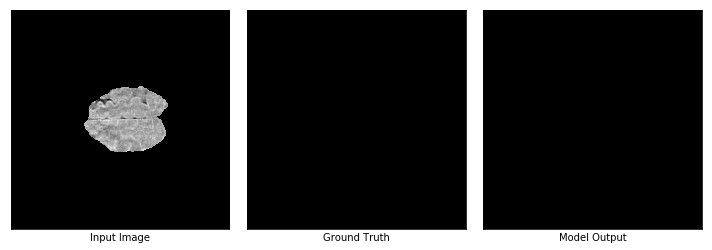

Steps: 4000, Loss:0.6061540842056274
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.1391443908214569, max:0.13115617632865906

Epochs  4


In [ ]:
epochs = 1
max_epochs = 30
#list
loss_list = []
acc_list = []
loss_inner = []
while epochs <= max_epochs:
    print()
    print("Epochs {:2d}".format(epochs))
    steps = 1
    dc_app = []
    sens_app = []
    spec_app = []
    for tf_re in sorted(os.listdir(tfrecords_read_dir)):
        tf_dir = os.path.join(tfrecords_read_dir+tf_re)
        dataset = utils.parse_tfrecord(tf_dir).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
        acc_inner = []
        for imgs in dataset:
            image = imgs[:,:,:,:4]
            #unprocessed label for plotting 
            label = imgs[:,:,:,-1]
            #for simplicity label 4 will be converted to 3 for sparse encoding
            label = tf.where(label==4,3,label)
            label = tf.keras.utils.to_categorical(label, num_classes=4)
            img_seg, loss, gradients = train_fn(image, label) #training function 
            #map from sparse to label
            img_seg = tf.math.argmax(img_seg,-1,output_type=tf.int32) 
            label = tf.math.argmax(label,-1,output_type=tf.int32)
            #accuracy of the output values for that batch
            acc = tf.reduce_mean(tf.cast(tf.equal(img_seg,label), tf.float32))
            #append accuracy for every steps
            acc_inner.append(acc)
            if epochs%5==0:
                dc_list, sens_list, spec_list =compute_metric(label,img_seg)
                dc_app.append(dc_list)
                sens_app.append(sens_list)
                spec_app.append(spec_list)
            #output
            if steps%2000==0:
                input_img = [image[0,:,:,0], plot_labels_color(label[0]), plot_labels_color(img_seg[0])]
                caption = ['Input Image', 'Ground Truth', 'Model Output']
                plot_comparison(input_img, caption, n_col = 3, figsize=(10,10))
                loss_list.append(loss)
                acc_stp = tf.reduce_mean(tf.cast(tf.equal(img_seg[0],label[0]), tf.float32))
                dc_list_stp, sens_list_stp, spec_list_stp =compute_metric(label[0],img_seg[0])
                print("Steps: {}, Loss:{}".format(steps, loss))
                print("Accurary: {}".format(acc_stp))
                print("Dice coefficient: {}".format(dc_list_stp))
                print("Sensitivity: {}".format(sens_list_stp))
                print("Specificity: {}".format(spec_list_stp))
                print("Gradient min:{}, max:{}".format(np.min(gradients[0]), np.max(gradients[0])))
            steps+=1
        acc_list.append(np.mean(acc_inner))
    if epochs%5==0:
        mean_dc = np.mean(np.array(dc_app),0)
        mean_sens = np.mean(np.array(sens_app),0)
        mean_spec = np.mean(np.array(spec_app),0)
        print()
        print('-----------<Summary for Epoch:{}>------------'.format(epochs))
        print("Mean Accuracy: {}".format(np.mean(acc_list)))
        print("Mean Dice coefficient: {}".format(mean_dc))
        print("Mean Sensitivity: {}".format(mean_sens))
        print("Mean Specificity: {}".format(mean_spec))
        print('------------------------------------------------')
        print()
    epochs+=1 

---

# Save Weights

In [ ]:
model.save_weights('/home/kevinteng/Desktop/model_weights/model_{}.h5'.format(ver))

---

# Validation 

In [ ]:
model.load_weights('/home/kevinteng/Desktop/model_weights/model_{}.h5'.format(ver))
def val_fn(image, label):
    model.trainable = False
    model_output = model(image)
    loss = xent(label, model_output)
    return model_output, loss

In [ ]:
tfrecords_val = '/home/kevinteng/Desktop/ssd02/BraTS20_tfrecords03/LGG/'

steps = 1
acc_list = []
for tf_re in sorted(os.listdir(tfrecords_val)):
    tf_dir = os.path.join(tfrecords_val+tf_re)
    dataset = utils.parse_tfrecord(tf_dir).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
    dc_app = []
    sens_app = []
    spec_app = []
    for imgs in dataset:
        image = imgs[:,:,:,:4]
        label = imgs[:,:,:,-1]
        label = tf.where(label==4,3,label)
        #for simplicity label 4 will be converted to 3 for sparse encoding
        label = tf.keras.utils.to_categorical(label, num_classes=4)
        img_seg, loss = val_fn(image, label) #validation function 
        #map from sparse to label
        img_seg = tf.math.argmax(img_seg,-1,output_type=tf.int32) 
        label = tf.math.argmax(label,-1,output_type=tf.int32)
        #accuracy of the output values for that batch
        acc = tf.reduce_mean(tf.cast(tf.equal(img_seg,label), tf.float32))
        dc_list, sens_list, spec_list =compute_metric(label,img_seg)
        #append
        acc_list.append(acc)
        dc_app.append(dc_list)
        sens_app.append(sens_list)
        spec_app.append(spec_list)
        #output
        if steps%100==0:
#             dc_list, sens_list, spec_list =compute_metric(label[0],img_seg[0])
            input_img = [image[0,:,:,0], plot_labels_color(label[0]), plot_labels_color(img_seg[0])]
            caption = ['Input Image', 'Ground Truth', 'Model Output']
            plot_comparison(input_img, caption, n_col = 3, figsize=(10,10))
            acc_stp = tf.reduce_mean(tf.cast(tf.equal(img_seg[0],label[0]), tf.float32))
            dc_list, sens_list, spec_list =compute_metric(label[0],img_seg[0])
            print("Steps: {}, Loss:{}".format(steps, loss))
            print("Accuracy: {}".format(acc_stp))
            print("Dice coefficient: {}".format(dc_list))
            print("Sensitivity: {}".format(sens_list))
            print("Specificity: {}".format(spec_list))
        steps+=1
    mean_dc = np.mean(np.array(dc_app),0)
    mean_sens = np.mean(np.array(sens_app),0)
    mean_spec = np.mean(np.array(spec_app),0)
    print("Mean Accuracy: {}".format(np.mean(acc_list)))
    print("Mean Dice coefficient: {}".format(mean_dc))
    print("Mean Sensitivity: {}".format(mean_sens))
    print("Mean Specificity: {}".format(mean_spec))

---

# Model Summary

In [ ]:
model.summary()